In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import shutil
import zipfile
import glob
import os
import time
from PIL import Image

In [3]:
# data_dir = './data/catdog'

# train_dir = os.path.join(data_dir, 'train')
# test_dir = os.path.join(data_dir, 'test')
# val_dir = os.path.join(data_dir, 'validation')

# dir_lst = [train_dir, test_dir, val_dir]

# for d in dir_lst:
    
#     file_lst = os.listdir(d)

#     for f in file_lst:
#         src = os.path.join(d, f)
#         dtr = os.path.join(data_dir, f)
#         shutil.move(src, dtr)

In [4]:
# gpu 연결
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)
print(device)

cpu


In [5]:
# 경로 설정
data_dir = './data/catdog'

train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'validation')

# os.mkdir(train_dir)
# os.mkdir(test_dir)
# os.mkdir(val_dir)

In [6]:
# data copy 
# train : cat 3000 / dog 3000 -> 6000
# test : cat 1000 / dog 1000 -> 2000
# validation : cat 1000 / dog 1000 -> 2000
dog_files = [f'dog.{i}.jpg' for i in range(12500)]
cat_files = [f'cat.{i}.jpg' for i in range(12500)]

# for dog, cat in zip(dog_files[:5000], cat_files[:5000]):
#     src = os.path.join(data_dir, dog)
#     dtr = os.path.join(train_dir, dog)
#     shutil.move(src, dtr)
#     src = os.path.join(data_dir, cat)
#     dtr = os.path.join(train_dir, cat)
#     shutil.move(src, dtr)
    
# for dog, cat in zip(dog_files[5000:6000], cat_files[5000:6000]):
#     src = os.path.join(data_dir, dog)
#     dtr = os.path.join(val_dir, dog)
#     shutil.move(src, dtr)
#     src = os.path.join(data_dir, cat)
#     dtr = os.path.join(val_dir, cat)
#     shutil.move(src, dtr)
    
# for dog, cat in zip(dog_files[6000:7000], cat_files[6000:7000]):
#     src = os.path.join(data_dir, dog)
#     dtr = os.path.join(test_dir, dog)
#     shutil.move(src, dtr)
#     src = os.path.join(data_dir, cat)
#     dtr = os.path.join(test_dir, cat)
#     shutil.move(src, dtr)

In [7]:
# file list create
os.listdir('./data/catdog')[-3:]

import glob

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
val_list = glob.glob(os.path.join(val_dir, '*.jpg'))

print(len(train_list), len(test_list), len(val_list))

10000 2000 2000


In [14]:
lr = 0.001 # learning_rate
batch_size = 16 # we will use mini-batch method
epochs = 20 # How much to train a model

In [33]:
# train_list[0].split('/')[-1].split('.')[0][-3:]

'cat'

In [8]:
#data Augumentation
#tensorflow : ImageGenerator
train_transform = transforms.Compose([
    transforms.Resize((256,256)), # 이미지 size 설정
    transforms.RandomCrop(224), # 랜덤으로 이미지를 (size, size) 크기로 crop
    transforms.RandomHorizontalFlip(), # 좌우반전 효과 적용
    transforms.ToTensor(), # [0,255] -> [0,1] 볌위 변환
])

'''
scaling이 항상 적용되는 것은 아니며, PIL image가 (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) mode중의 하나이거나, 
numpy array의 dtype이 np.unit8인 경우에 scaling이 적용됩니다.
'''

test_transform = transforms.Compose([
    transforms.Resize((224,244)),
    transforms.ToTensor(),
])


In [9]:
# Labeling / transform apply
class dataset(torch.utils.data.Dataset):
    #가져와서 처리
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
        
    #dataset length : 6000 / 2000 / 2000
    def __len__(self):
        self.filelength = len(self.file_list) 
        return self.filelength
    
    #load an one of images
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[0][-3:]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0

        return img_transformed, label


In [10]:
# dataset create
train_data = dataset(train_list, transform=train_transform)
test_data = dataset(test_list, transform=test_transform)
val_data = dataset(val_list, transform=test_transform)

print(f'number of train dataset : {len(train_data)}')
print(f'number of valid dataset : {len(val_data)}')
print(f'number of test dataset : {len(test_data)}')

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=32, shuffle=True ) 
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=32, shuffle=True)

print(f'number of train loader : {len(train_loader)}')
print(f'number of valid loader : {len(test_loader)}')
print(f'number of test loader : {len(val_loader)}')

number of train dataset : 10000
number of valid dataset : 2000
number of test dataset : 2000
number of train loader : 313
number of valid loader : 63
number of test loader : 63


32 32
torch.Size([32, 3, 224, 224])


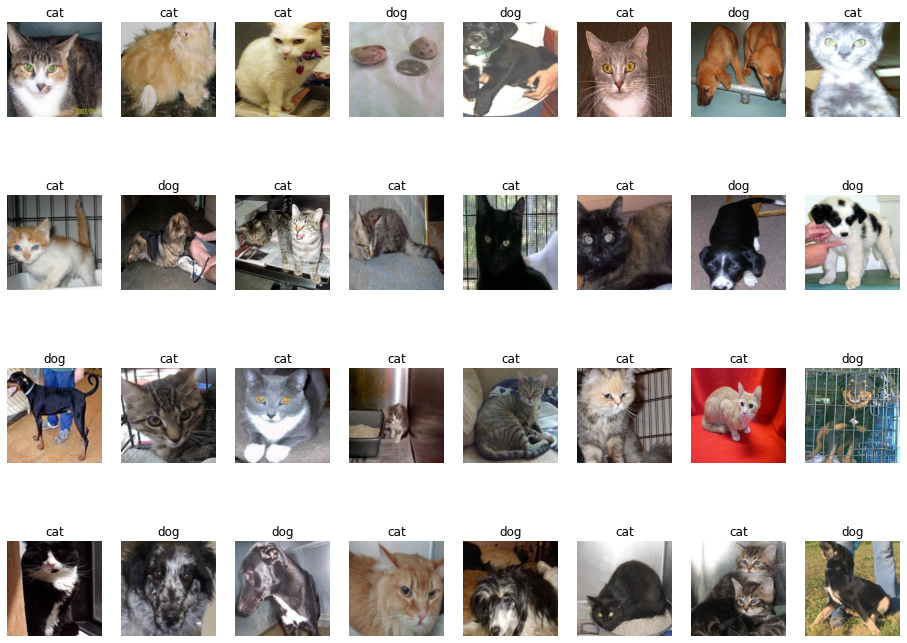

In [12]:
samples, labels = iter(train_loader).next()
print(len(samples), len(labels)) # batch size
print(samples.size()) # [batchsize, rgb , img_shape[0], img_shape[1]]

classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))

# 1 data (16 batch) 당 들어있는 data image 시각화
for i in range(32):
    a = fig.add_subplot(4,8,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [13]:
samples, labels = iter(train_loader).next()
print(len(samples), len(labels)) # batch size
print(samples.size()) # [batchsize, rgb , img_shape[0], img_shape[1]]
print(labels.unique()) # label : 0 cat / 1 dog

32 32
torch.Size([32, 3, 224, 224])
tensor([0, 1])


In [14]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        # Conv2d(in_channels(rgb), out_channel(conv hidden layer), kernel_size(filter), stride=1, padding=0)
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
            ) # (224,224) -> (55,55)
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            ) # (55,55) -> (13,13)
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
            ) # (13,13) -> (3,3)
        
        self.fc1 = nn.Linear(3*3*64,10) # (3,3) * hidden layer(64) * custom(10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2) # input(10) * output(2 : label count)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1) # out.size = 3x3x64 -> 3x192
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out
    
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [15]:
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss() # include softmax

In [19]:
# model train
# tensorflow : fit_generator
epochs = 10

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in train_loader: # 313
        data = data.to(device)
        label = label.to(device)
        
        output = model(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
        
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy, epoch_loss))
    
    
    with torch.no_grad():
        epoch_val_accuracy=0
        epoch_val_loss =0
        
        for data, label in val_loader: # 63
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output,label)
            
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)
            
        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))

Epoch : 1, train accuracy : 0.6742216348648071, train loss : 0.6014295220375061
Epoch : 1, val_accuracy : 0.7182542085647583, val_loss : 0.5447226166725159
Epoch : 2, train accuracy : 0.7513975501060486, train loss : 0.5095817446708679
Epoch : 2, val_accuracy : 0.7673614025115967, val_loss : 0.49313580989837646
Epoch : 3, train accuracy : 0.7857421636581421, train loss : 0.4622822403907776
Epoch : 3, val_accuracy : 0.789682924747467, val_loss : 0.45015808939933777
Epoch : 4, train accuracy : 0.7934297323226929, train loss : 0.44392234086990356
Epoch : 4, val_accuracy : 0.7901788949966431, val_loss : 0.45838963985443115
Epoch : 5, train accuracy : 0.8061093091964722, train loss : 0.4245486259460449
Epoch : 5, val_accuracy : 0.7986114025115967, val_loss : 0.42470571398735046
Epoch : 6, train accuracy : 0.8170915246009827, train loss : 0.4087595045566559
Epoch : 6, val_accuracy : 0.8249010443687439, val_loss : 0.3948039412498474
Epoch : 7, train accuracy : 0.8173909783363342, train loss :

In [24]:
# test
dog_probs = []
model.eval()
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        dog_probs += list(zip(list(fileid), preds_list))

In [25]:
dog_probs.sort(key = lambda x : int(x[0]))
print(len(dog_probs))

2000


In [26]:
idx = list(map(lambda x: x[0],dog_probs))
prob = list(map(lambda x: x[1],dog_probs))
submission = pd.DataFrame({'id':idx,'label':prob})
submission

,id,label
0,tensor(0),0.145913
1,tensor(0),0.081937
2,tensor(0),0.033294
3,tensor(0),0.466536
4,tensor(0),0.282662
...,...,...
1995,tensor(1),0.366767
1996,tensor(1),0.978526
1997,tensor(1),0.981696
1998,tensor(1),0.984307


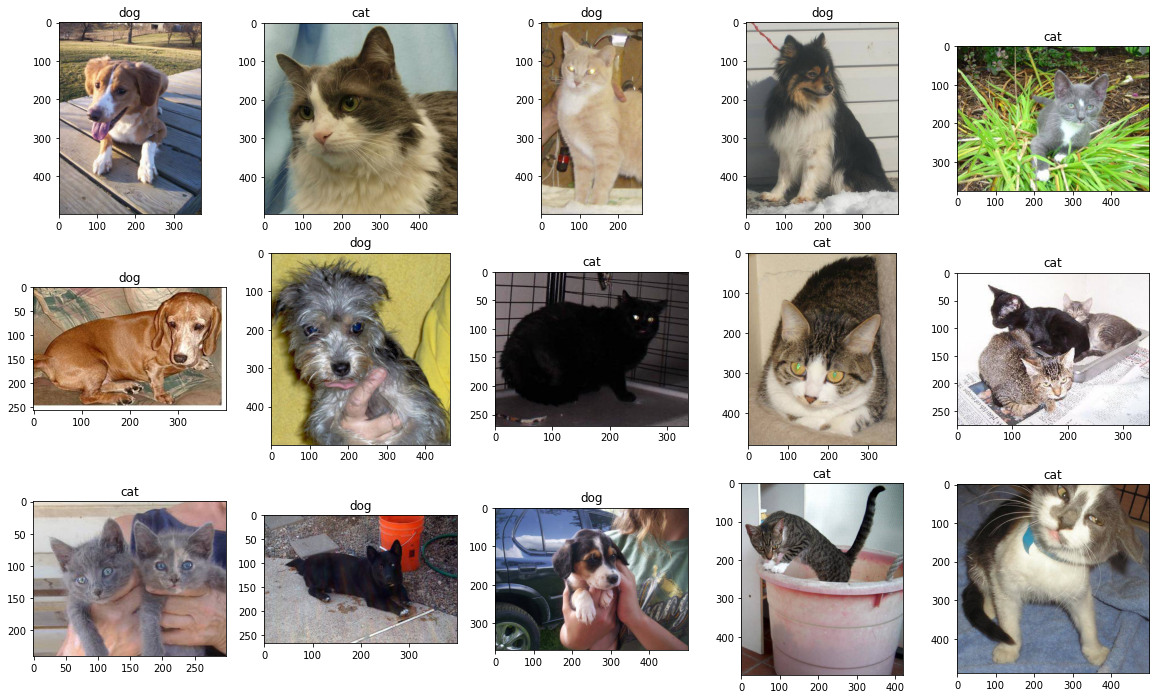

In [29]:
import random

id_list = []
class_ = {0: 'cat', 1: 'dog'}

fig, axes = plt.subplots(3, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission.index.values)
    
    label = submission.loc[submission.index == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(test_dir, '{}.jpg'.format('.'.join(test_list[i].split('\\')[-1].split('.')[:2])))
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)